# Data Preprocessing and Normalization

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
df = pd.read_csv(r'C:\Users\kevin\Desktop\VSCode\ScaleDux\Startup_Scoring_Dataset.csv')
df.head()

,startup_id,team_experience,market_size_million_usd,monthly_active_users,monthly_burn_rate_inr,funds_raised_inr,valuation_inr
0,S001,7,789,66299,6091495,4183839,263247468
1,S002,4,939,34866,9106842,666326,172927107
2,S003,8,42,73630,8817088,649150,313090455
3,S004,5,57,93657,6374167,20153173,305887183
4,S005,7,512,61187,841971,118834,84815222


In [4]:
df.drop('startup_id', axis=1, inplace=True)

In [5]:
df['monthly_burn_rate_inr'] = df['monthly_burn_rate_inr'].max() - df['monthly_burn_rate_inr']

In [6]:
num_cols = df.select_dtypes(include=['int64']).columns

In [7]:
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Feature Engineering

In [8]:
# Defining weights for each feature
weights = {
    'team_experience': 15,
    'market_size_million_usd': 20,
    'monthly_active_users': 25,
    'monthly_burn_rate_inr': 10,
    'funds_raised_inr': 15,
    'valuation_inr': 15
}

In [9]:
features = list(weights.keys())

In [10]:
# Calculate composite score by multiplying each feature by its weight and summing them up
df['composite_score'] = sum(df[col] * weight for col, weight in weights.items())

In [11]:
X = df.drop('composite_score', axis=1).values.astype(np.float32)
y = df['composite_score'].values.astype(np.float32)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train).to(DEVICE)
X_test_tensor = torch.tensor(X_test).to(DEVICE)
y_train_tensor = torch.tensor(y_train).view(-1, 1).to(DEVICE)
y_test_tensor = torch.tensor(y_test).view(-1, 1).to(DEVICE)

# Model Training and Evaluation

In [14]:
# Define the neural network model
class RegressionNN(nn.Module):
    def __init__(self, input_dim):
        super(RegressionNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x)

In [15]:
# Initialize the model, loss function, and optimizer
model = RegressionNN(len(features)).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [16]:
# Train the model
epochs = 300
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

In [17]:
# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).cpu().numpy().flatten()
    y_true = y_test_tensor.cpu().numpy().flatten()
    r2 = r2_score(y_true, predictions)
    mse = mean_squared_error(y_true, predictions)
    mae = mean_absolute_error(y_true, predictions)
    rmse = np.sqrt(mse)

print(f"R^2 Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

R^2 Score: 0.9632
Mean Squared Error: 7.9200
Mean Absolute Error: 2.2428
Root Mean Squared Error: 2.8142


In [18]:
# Extracting feature importances

first_layer_weights = model.model[0].weight.data.cpu().numpy()
feature_importance = np.mean(np.abs(first_layer_weights), axis=0)

In [19]:
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

In [20]:
print("\nFeature Importances from PyTorch Model (First Layer Weights):")
print(importance_df)


Feature Importances from PyTorch Model (First Layer Weights):
                   Feature  Importance
2     monthly_active_users    0.485411
1  market_size_million_usd    0.376948
4         funds_raised_inr    0.366369
5            valuation_inr    0.317693
0          team_experience    0.312095
3    monthly_burn_rate_inr    0.268482


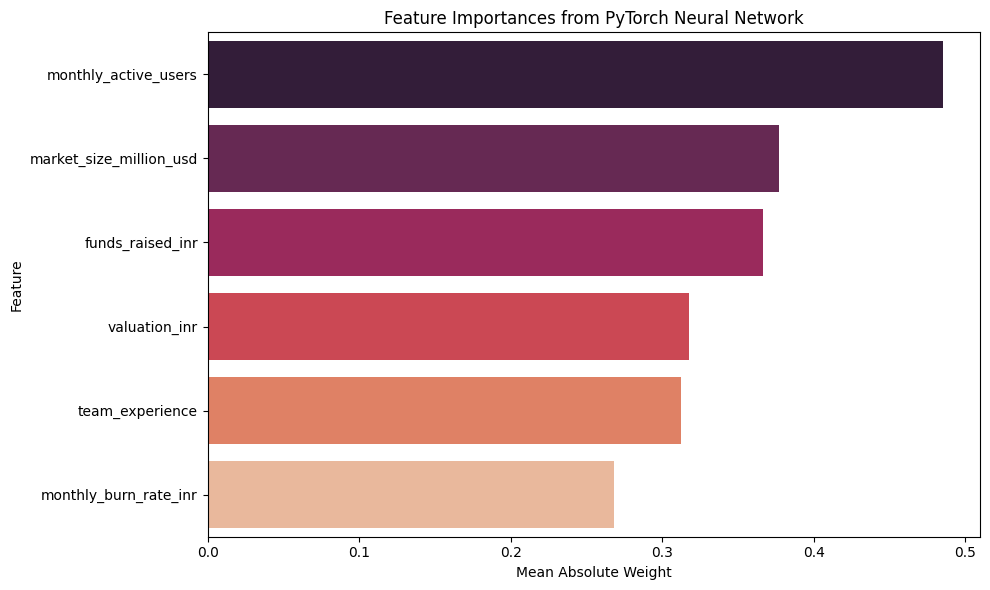

In [21]:
# Plotting feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='rocket')
plt.title('Feature Importances from PyTorch Neural Network')
plt.xlabel('Mean Absolute Weight')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig(r'C:\Users\kevin\Desktop\VSCode\ScaleDux\output\feature_importances_pytorch.png')
plt.show()